**Setup**

In [ ]:
# Import libraries
import re
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# Mount Google Drive (not necessary if you access your data else)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load raw data
path_to_file = '/content/drive/My Drive/data/claims_embeddings_11282023.pkl' # Adapt path
df = pd.read_pickle(path_to_file)

**Descriptive Analysis**

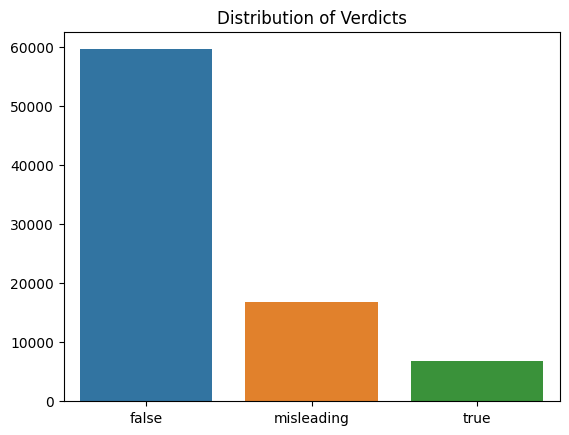

In [ ]:
# Distribution of verdicts
verdict_counts = df['verdict'].value_counts()
sns.barplot(x=verdict_counts.index, y=verdict_counts.values)
plt.title('Distribution of Verdicts')
plt.show()

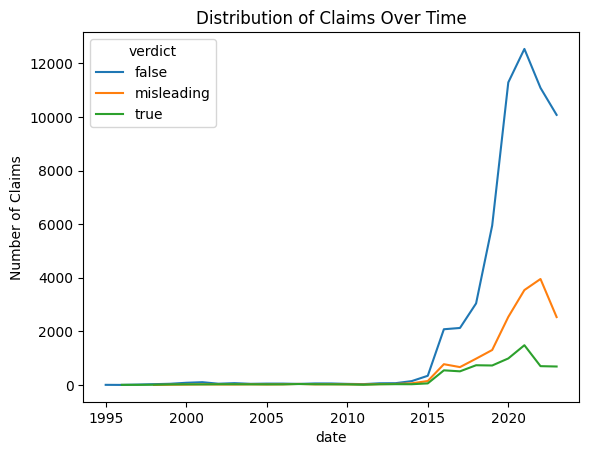

In [ ]:
# Distribution over time
df['date'] = pd.to_datetime(df['date'])
df.groupby([df['date'].dt.year, 'verdict']).size().unstack().plot(kind='line')
plt.title('Distribution of Claims Over Time')
plt.ylabel('Number of Claims')
plt.show()

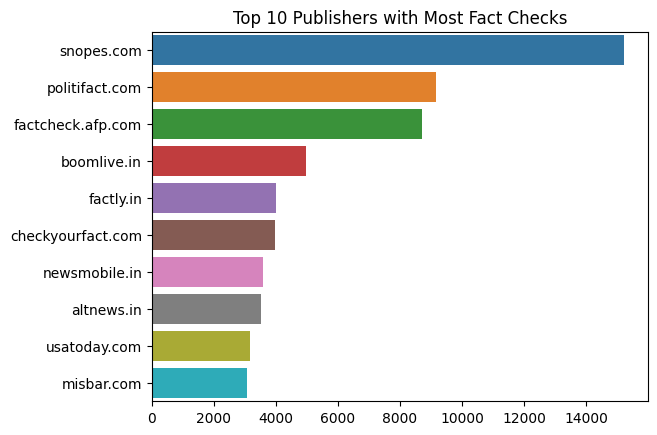

In [ ]:
# Top 10 publishers
top_publishers = df['publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('Top 10 Publishers with Most Fact Checks')
plt.show()

**Topic Modeling**

In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Adapt stopwords list and load lemmatizer
stop_words = set(stopwords.words('english'))
custom_stops = {'Twitter', 'Facebook', 'Instagram', 'YouTube', 'Joe Biden', 'Donald Trump', 'Video', 'Show', 'Image', 'US', 'Nigeria', 'Nigerian', 'Buhari', 'Lagos'} # Adapt depending on your context
stop_words.update(custom_stops)
lemmatizer = WordNetLemmatizer()

In [ ]:
# Define cleaning function
def clean_text(text):
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)

    # Convert to lowercase and split into words
    words = text.lower().split()

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return " ".join(words)

In [ ]:
# Apply the cleaning function to your DataFrame
df['claim_clean'] = df['claim'].apply(clean_text)

In [ ]:
# Initialize a CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [ ]:
# Fit and transform the cleaned claims
X = vectorizer.fit_transform(df['claim_clean'])

In [ ]:
# Initialize LDA and fit it to the transformed data
lda = LatentDirichletAllocation(n_components=10, random_state=42) # Adapt/iterate over different number of topic clusters (n_components) depending on your task and data
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [ ]:
# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
# Investigate topics to manually determine labels
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
year world child cause school cancer health human rate woman
Topic 1:
video south china india water africa car sri photo image
Topic 2:
video muslim photo woman man recent hindu police image pakistan
Topic 3:
people mask city wearing new photograph say illegal face image
Topic 4:
trump president donald biden joe said election say state obama
Topic 5:
modi pm minister government photo bjp congress video prime party
Topic 6:
facebook claim medium social twitter post protest police user national
Topic 7:
video president russian ukraine gandhi photo marcos ukrainian philippine soldier
Topic 8:
covid vaccine people coronavirus new pandemic death died virus video
Topic 9:
say clinton hillary law attack state million gun terrorist said


In [ ]:
# Get topic distribution for each document
topic_distributions = lda.transform(X)

In [ ]:
# Find the dominant topic (with the highest probability) for each document
dominant_topic = np.argmax(topic_distributions, axis=1)
df['dominant_topic'] = dominant_topic

In [ ]:
# Manually assign labels based on LDA results
topic_labels = {
    0: "Health and Education",
    1: "International Affairs and Environment",
    2: "Religious and Cultural Issues",
    3: "Public Health and Safety",
    4: "US Politics",
    5: "Indian Politics",
    6: "Social Media",
    7: "Global Politics and Conflicts",
    8: "COVID-19 Pandemic",
    9: "Terrorism and Security"
}

In [ ]:
# Attach labels to data frame
df['label'] = df['dominant_topic'].map(topic_labels)

In [ ]:
# Double check data frame columns
df.columns

Index(['claim', 'claimant', 'verdict', 'date', 'url', 'publisher',
       'languageCode', 'claim_id', 'claim_clean', 'dominant_topic', 'label'],
      dtype='object')

In [ ]:
# Save results
file_path = '/content/drive/My Drive/World Bank Consultancy/Data/fact_checks_11272023_topic-modeling.pkl'
df.to_pickle(file_path)

**Topic Patterns over Time**

*Please note that all visualizations were created with Tableau Desktop.*